<a href="https://colab.research.google.com/github/titokenzo/redes_neurais_pos/blob/main/SOM/Self_Organizing_Map_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/titokenzo/redes_neurais_pos.git

Cloning into 'redes_neurais_pos'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 65 (delta 13), reused 2 (delta 1), pack-reused 0
Unpacking objects: 100% (65/65), done.


# Self-Organizing Maps Network

Código exemplo da rede neural SOM.

Código adaptado do site:

http://blog.yhat.com/posts/self-organizing-maps-2.html

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from sklearn import preprocessing
from matplotlib.cm import get_cmap

##Configuração da SOM

Escolhe:
1. Tamanho do mapa da SOM: X e Y
2. Número de iterações
3. Taxa de aprendizado
4. Tipo de normalização dos dados
5. Largura inicial (Sigma) 
6. Constante de tempo que descresce com o tempo

In [ ]:
class SOM:
    def __init__(self, X_dimension, Y_dimension, train_data, number_of_features=0, labels_data=None):
        self.has_labels = False
        self.number_of_features = number_of_features
        self.train_data = train_data
        if(labels_data is not None):
            self.labels_data = labels_data
            self.initialize_labels(X_dimension, Y_dimension)
        #define o tamanho do mapa a partir de X_dimension e Y_dimension
        self.network_dimensions = np.array([X_dimension, Y_dimension])
        self.m = data.shape[1]
        self.n = data.shape[0]
        
        #cria raio inicial de acordo com o tamanho inicial do mapa da SOM
        self.initial_radius = max(self.network_dimensions[0], self.network_dimensions[1]) / 2
        self.initialize_weigths()

    def initialize_weigths(self):
        # inicialização dos pesos m=dimensional pra cada neurônio da matriz SOM
        self.net = np.random.random((self.network_dimensions[0], self.network_dimensions[1], self.m))
        #print("Net:",self.net)
    
    def initialize_labels(self, X_dimension, Y_dimension):
        #transforma rótulos do conjunto de treinamento em numeros pra mostrar no mapa
        le = preprocessing.LabelEncoder()
        le.fit(labels.values)
        self.training_labels_transformed = le.transform(labels.values)
        self.classes = le.classes_
        #modifica para a quantidade de "labels" existentes no vetor
        self.number_of_features = len(self.classes)
        self.label_map = np.zeros((X_dimension, Y_dimension, len(self.classes)))
        self.has_labels = True
        #print("Classes:", self.classes)
        
    def train(self, number_of_epochs, initial_learning_rate=0.01, distance_calculation="Euclidiana"):
        """
        Função de treinamento da SOM.

        Parameters
        ----------
        number_of_epochs : int
            Número de iterações.
        initial_learning_rate : float, optional
            Taxa de aprendizagem inicial. The default is 0.01.
            É ajustada dentro da função.
        distance_calculation : string, optional
            Informa o tipo de cálculo para a distância. The default is Euclidiana.

        Returns
        -------
        None.

        """
        self.time_constant = number_of_epochs / np.log(self.initial_radius)
        
        for i in range(number_of_epochs):
            #print('Epoch %d' % i)
            #seleciona um exemplo aleatoriamente da base de dados
            random_example = np.random.randint(0, self.n)
            train_row = self.train_data.iloc[random_example].values.reshape(np.array([self.m, 1]))
            #print(train_row)
          
            #calcula neurônio mais próximo a este exemplo (BMU)
            bmu, bmu_idx = self.find_bmu(train_row)
            #print("bmu={}, bmu_idx{}".format(bmu, bmu_idx))
            
            if(self.has_labels):
                #TODO self.register_example_class(random_example,)
                #seleciona a classe do exemplo (Apenas pra vias de informação no mapa)
                class_index = list(self.classes).index(self.labels_data[random_example])
                lab = self.label_map[bmu_idx[0],bmu_idx[1]]  
                lab[class_index] = lab[class_index]+1
                #associa o neurônio a esta classe
                self.label_map[bmu_idx[0],bmu_idx[1]] = lab
            
            # Decresce os parâmetros da SOM
            radius = self.decay_radius(i)
            learning_rate = self.decay_learning_rate(initial_learning_rate,i,number_of_epochs)
            #r = decay_radius(init_radius, i, time_constant)
            #l = decay_learning_rate(init_learning_rate, i, n_iterations)
            
            # Atualiza o vetor de Pesos da rede SOM para todos os neurônios da rede
            for x in range(self.net.shape[0]):
                for y in range(self.net.shape[1]):
                    weight = self.net[x, y, :].reshape(self.m,1)
                    # calcula a distância do neurônio ao neurônio vencedor
                    if(distance_calculation=="Euclidiana"):
                        w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
                    else:
                        w_dist = np.sum(abs(np.array([x, y]) - bmu_idx))
                    # se distância está dentro do raio estipulado r^2
                    if w_dist <= radius**2:
                        # calcula a função de vizinhança
                        influence = self.compute_neighborhood(w_dist, radius)
                        # atualiza os pesos
                        # w(t+1) = w(t) + (learning rate * h * distancia)
                        new_weight = weight + (learning_rate * influence * (train_row - weight))
                        # coloca o novo peso na rede na posição X,Y
                        self.net[x, y, :] = new_weight.reshape(1, self.m)
    
    def find_bmu(self,train_row):
        """
        Encontra o neurônio vencedor pra um dado vetor de entrada, t, na rede SOM
    
        Parameters
        ----------
        training_row : array
            Vetor de entrada.
        number_of_columns : int
            DESCRIPTION.
    
        Returns
        -------
        bmu : TYPE
            É o neurônio vencedor BMU.
        bmu_idx : TYPE
            É a coordenada do vetor na rede SOM.
    
        """
        bmu_idx = np.array([0, 0])
        # define um número grande pra distância mínima inicial 
        min_dist = np.iinfo(np.int).max   
        # calcula a distância entre cada neurônio e a entrada
        # for (k = 1,..., K)
        for x in range(self.net.shape[0]):
            for y in range(self.net.shape[1]):
                weight = self.net[x, y, :].reshape(self.m, 1)
                sq_dist = np.sum((weight - train_row) ** 2)
                if sq_dist < min_dist:
                    min_dist = sq_dist
                    bmu_idx = np.array([x, y])
        # obtém o vetor correspondente a bmu_idx
        bmu = self.net[bmu_idx[0], bmu_idx[1], :].reshape(self.m, 1)
        return (bmu, bmu_idx)
    
    def decay_radius(self, iteration):
        return self.initial_radius * np.exp(-iteration / self.time_constant)
    
    def decay_learning_rate(self, initial_learning_rate, iteration, number_of_epochs):
        return initial_learning_rate * np.exp(-iteration / number_of_epochs)
    
    def compute_neighborhood(self, distance, radius):
        return np.exp(-distance / (2* (radius**2)))
    
    def show_plot(self, fig, number_of_epochs):
        #fig = plt.figure()
        # setup axes
        ax = fig.add_subplot(111, aspect='equal')
        ax.set_xlim((0, som.net.shape[0]+1))
        ax.set_ylim((0, som.net.shape[1]+1))
        ax.set_title('Self-Organising Map after %d iterations' % number_of_epochs)
        
        cores = get_cmap('tab20').colors + get_cmap('tab20b').colors
        ajusta_cores = int(len(cores) / len(som.classes))
        
        # plot the rectangles
        for x in range(1, som.net.shape[0] + 1):
            for y in range(1, som.net.shape[1] + 1):
                #print(som.net[x-1,y-1,:])
                m = som.label_map[x-1,y-1]
                name_class = som.classes[np.argmax(m)]
                
                cor = cores[np.argmax(m) * ajusta_cores] 
                #print("Classe:{}, ArgMax:{}, Valores:{}".format(name_class, np.argmax(m), som.net[x-1,y-1,:]))
                ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                             facecolor=cor,
                             alpha = np.max(som.net[x-1,y-1,:]),
                             edgecolor='none',label='sdsad'))
                ax.text(x,y, name_class,
                        horizontalalignment='left', verticalalignment='center',
                        fontsize=6, color='black')
        plt.show()

## Carrega base de dados

Carrega base de dados e retorna os dados normalizados. 

Note que não há divisão entre treinamento e teste, pois se trata de um problema não supervisionado. Toda a base de dados é utilizada pra treinar o modelo.

In [ ]:
def load_data(url, normalize_data=True, normalize_by_column=False):
    '''
    Carrega (e normaliza) a base de dados (csv).

    Parameters
    ----------
    url : String
        Caminho do arquivo.
    normalize_data : boolean
        Se True (padrão), normaliza em relação a toda a base de dados.
        Se False, normaliza entre 0 e 1, levando em conta cada coluna.
    normalize_by_column : boolean
        DESCRIPTION.

    Returns
    -------
    normalized_data : list
        DESCRIPTION.
    labels : list
        DESCRIPTION.

    '''
    df = pd.read_csv(url, header=None)
    #remove a ultima coluna (dados)
    data = df[df.columns[:-1]]
    #retorna a última coluna (rótulos)
    labels = df[df.columns[-1]]
    # check if data needs to be normalised
    if normalize_data:
      if normalize_by_column:
        # normalise along each column
        col_maxes = data.max(axis=0)
        normalized_data = (data - col_maxes.min()) / (col_maxes.max() - col_maxes.min())
      else:
        # normalise entire dataset
        normalized_data = (data - data.min()) / (data.max() - data.min())
    return normalized_data, labels


Rede Neural SOM

In [ ]:
def find_bmu(t, net, m):
    """
        Encontra o neurônio vencedor pra um dado vetor de entrada, t, na rede SOM
        Retorna: (bmu, bmu_idx) onde bmu é o neurônio vencedor BMU
                 e bmu_idx é a coordenada do vetor na rede SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    # define um número grande pra distância mínima inicial 
    min_dist = np.iinfo(np.int).max   
    # calcula a distância entre cada neurônio e a entrada
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # obtém o vetor correspondente a bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # retorna (bmu, bmu_idx)
    return (bmu, bmu_idx)

In [ ]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

#neighborhood
def compute_neighborhood(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

Aprendizado SOM

## Algoritmo da rede SOM


Etapa 0: posicione aleatoriamente os neurônios no mapa da rede SOM.

Etapa 1: selecione um exemplo da base de dados, aleatoriamente ou sistematicamente no conjunto de dados

Etapa 2: encontre o neurônio mais próximo do ponto de dados escolhido. Esse neurônio é chamado de Unidade de Melhor Similaridade (BMU - Best Unit Matching).

Etapa 3: Mova a BMU para mais perto desse ponto de dados. A distância movida pela BMU é determinada por uma taxa de aprendizado, que diminui após cada iteração.

Etapa 4: aproxime também os vizinhos da BMU desse ponto de dados, com os vizinhos mais distantes se movendo menos. Os vizinhos são identificados usando um raio ao redor da BMU (função de vizinhança), e o valor desse raio diminui após cada iteração.

Etapa 5: atualize a taxa de aprendizado e o raio da BMU, antes de repetir as etapas 1 a 4. Repita essas etapas até que as posições dos neurônios tenham sido estabilizadas.

In [ ]:
local = 'redes_neurais_pos/RBF/iris.csv'
#local = 'redes_neurais_pos/SOM/letter.csv'
data,labels = load_data(url=local, normalize_data=True, normalize_by_column=False)
iterations = 10000

som = SOM(X_dimension=10, Y_dimension=10, train_data=data, labels_data=labels)

#som.train(number_of_epochs=10000, initial_learning_rate=0.01, do_reset_weights=False):
som.train(number_of_epochs=iterations)

## Visualiza o mapa criado

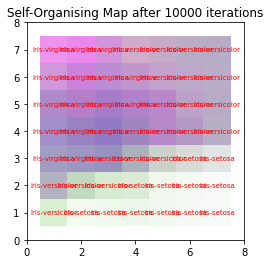

In [ ]:
fig = plt.figure()
som.show_plot(fig, iterations)

#Mini-Projeto rede SOM:

DATA DE ENTREGA: 02/12/2020


1. Execute a Redes Neurais SOM acima com a base de dados Iris. Mostre 5 configurações de tamanho de mapa diferentes.

2. Calcule a distância de Manhatan no lugar da euclidiana. Mostre os mesmos 5 mapas da questão anterior


3. Apresente os mesmos mapas da primeira questão pra outra base de dados de sua escolha. (Ex: Wine, Diabetes, Breast-Cancer, Letter, Digits)

 
 